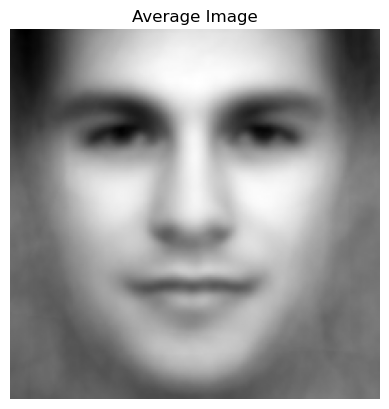

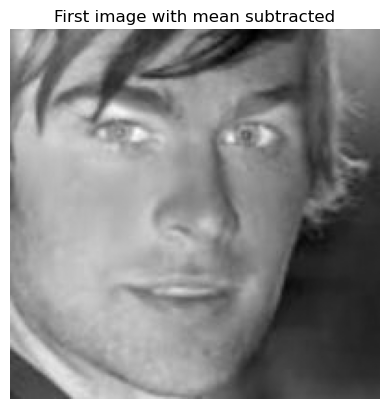

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

h = w = 200
ratings_csv = pd.read_csv("../post/s250200.csv")
ratings = ratings_csv[["Score1", "Score2"]].mean(axis=1).values

images = [] # flattened images (N, H*W)
for fname in ratings_csv["Image"]:
    img = Image.open("../" + fname)
    img = np.array(img).flatten()
    images.append(img)

mean_image = np.mean(images, axis=0)
images -= mean_image # center the data (subtract the mean image)

plt.imshow(mean_image.reshape((h, w)), cmap="gray")
plt.title("Average Image")
plt.axis("off")
plt.show()

plt.imshow(images[0].reshape((h, w)), cmap="gray")
plt.title("First image with mean subtracted")
plt.axis("off")
plt.show()

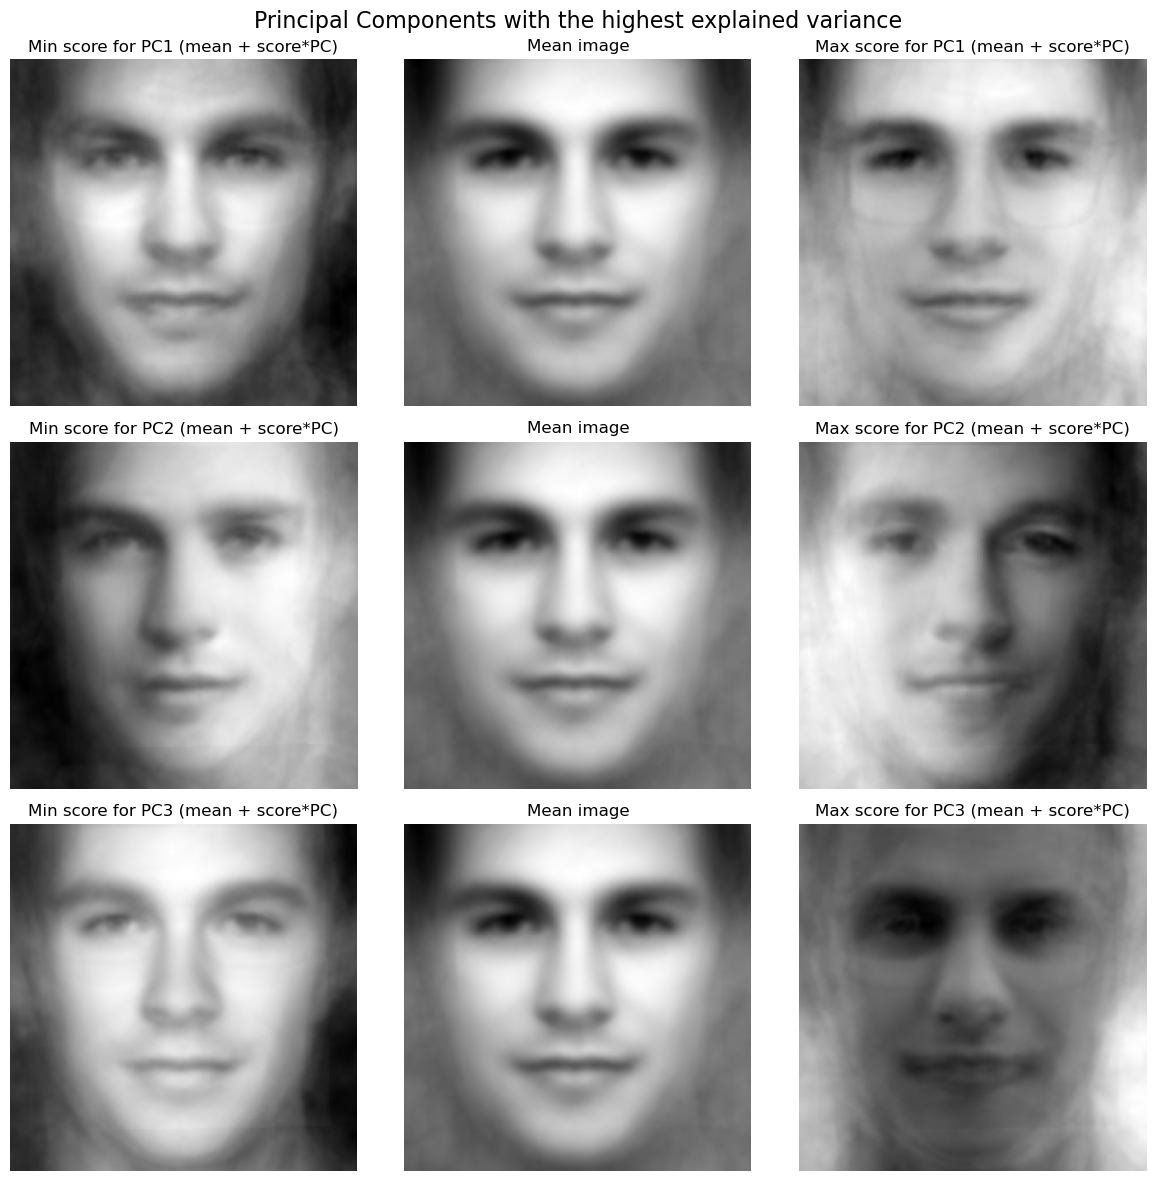

In [2]:
from sklearn.decomposition import PCA

pca = PCA()
A = pca.fit_transform(images)  # Coefficients (scores), shape: (num_images, num_components)
W = pca.components_            # Principal components, shape: (num_components, num_pixels)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for pc in range(3):
    pc_scores = A[:, pc]
    min_score = pc_scores[np.argmin(pc_scores)]
    max_score = pc_scores[np.argmax(pc_scores)]

    # Reconstruct images along this principal component:
    min_img = (mean_image + min_score * W[pc]).reshape((h, w))
    max_img = (mean_image + max_score * W[pc]).reshape((h, w))

    # Image for minimum score (mean + min_score * PC)
    axes[pc, 0].imshow(min_img, cmap="gray")
    axes[pc, 0].set_title(f"Min score for PC{pc + 1} (mean + score*PC)")
    axes[pc, 0].axis("off")

    # Mean visualization
    axes[pc, 1].imshow(mean_image.reshape((h, w)), cmap="gray")
    axes[pc, 1].set_title(f"Mean image")
    axes[pc, 1].axis("off")

    # Image for maximum score (mean + max_score * PC)
    axes[pc, 2].imshow(max_img, cmap="gray")
    axes[pc, 2].set_title(f"Max score for PC{pc + 1} (mean + score*PC)")
    axes[pc, 2].axis("off")

plt.suptitle("Principal Components with the highest explained variance", fontsize=16)
plt.tight_layout()
plt.show()

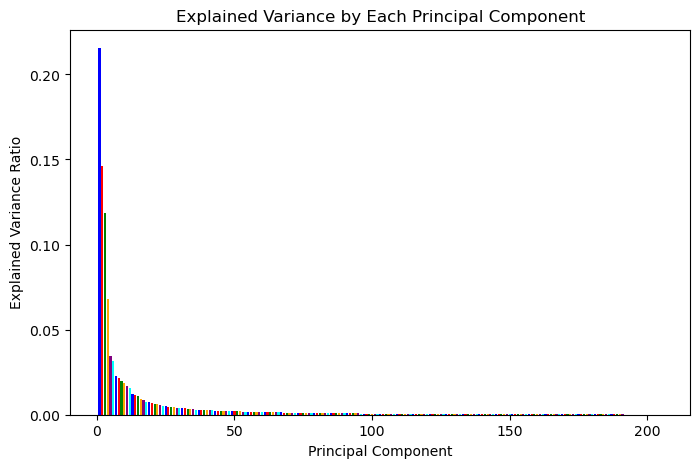

Number of principal components before explained variance increase drops below 1%: 5


In [3]:
plt.figure(figsize=(8, 5))
alt_colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan']
bar_colors = [alt_colors[i % len(alt_colors)] for i in range(len(pca.explained_variance_ratio_))]
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color=bar_colors)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Each Principal Component')
plt.show()

thresh_comps = np.argmax(np.diff(pca.explained_variance_ratio_) > -0.01) + 1; 
print(f"Number of principal components before explained variance increase drops below 1%: {thresh_comps}")
thresh_comps = 15

Baseline - MSE: 1.1869, RMSE: 1.0895, R2: 0.0000
Full model - MSE: 1.2565, RMSE: 1.1209, R2: 0.1265


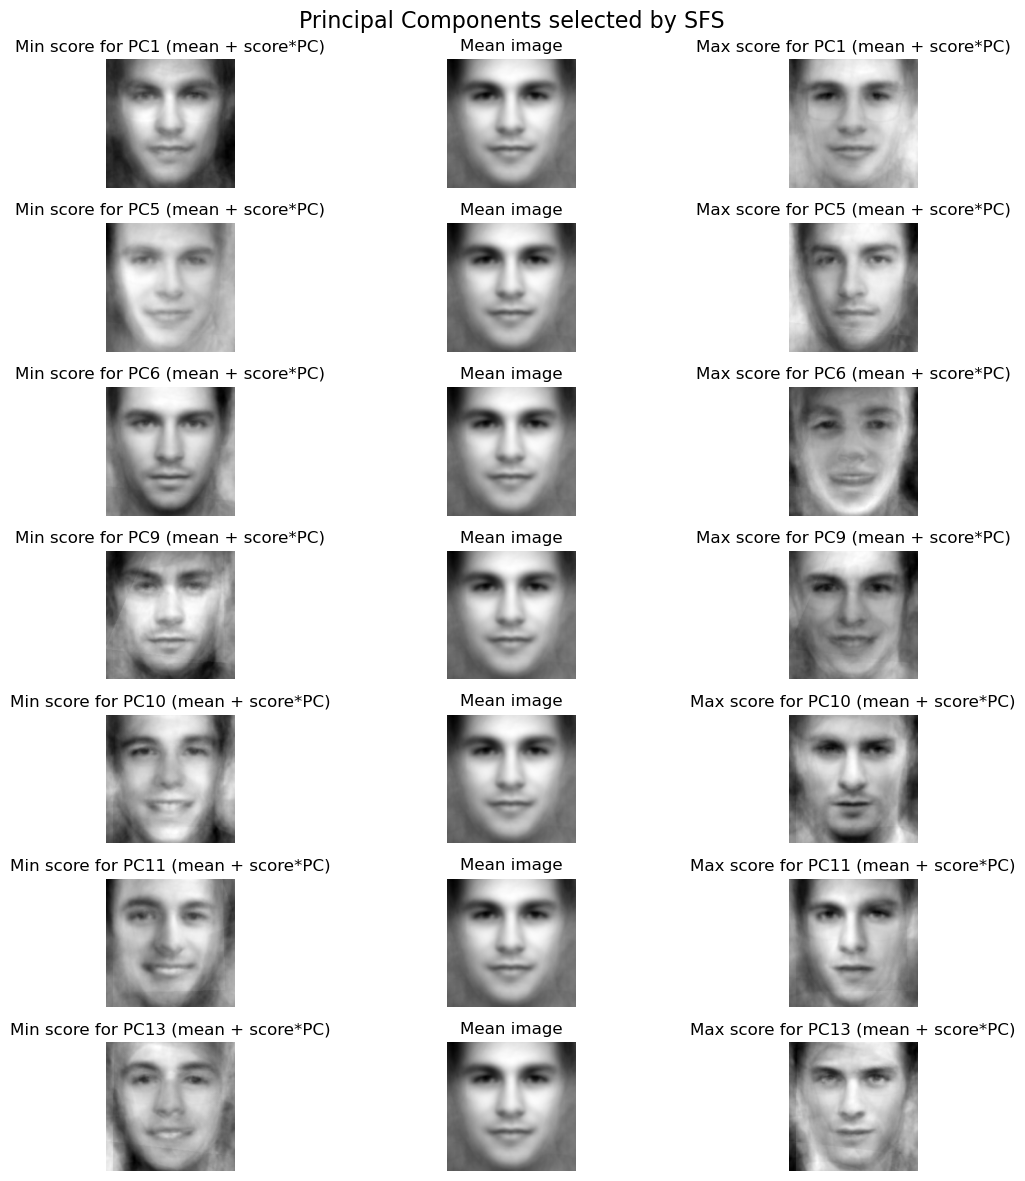

Selected PCs model (Intercept: 3.0310, Coefficients: [-3.3586e-06  5.8207e-05 -8.6054e-05  1.7444e-05  1.2149e-04  4.4694e-05
  1.2245e-04]) - MSE: 1.2092, RMSE: 1.0996, R2: 0.1594


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = A[:, :thresh_comps]  # Use only the components for 90% variance
y = ratings

# -------------------------------
# Baseline (mean predictor)
# -------------------------------

baseline_pred = np.full_like(y, y.mean(), dtype=float)
baseline_mse = mean_squared_error(y, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2 = r2_score(y, baseline_pred)
print(f"Baseline - MSE: {baseline_mse:.4f}, RMSE: {baseline_rmse:.4f}, R2: {baseline_r2:.4f}")

# -------------------------------
# Linear regression (all features)
# -------------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Full model - MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# -------------------------------
# Linear regression with feature selection (SFS + CV)
# -------------------------------
sfs = SequentialFeatureSelector(
    LinearRegression(),
    # n_features_to_select="auto",
    # direction="forward",
    scoring="r2",
    # cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)
sfs.fit(X, y)
selected_idx = list(np.where(sfs.get_support())[0])  # 0-based PC indices

# Show the principal components
fig, axes = plt.subplots(len(selected_idx), 3, figsize=(12, 12))
for i, pc in enumerate(selected_idx):
    pc_scores = A[:, pc]
    min_score = pc_scores[np.argmin(pc_scores)]
    max_score = pc_scores[np.argmax(pc_scores)]

    # Reconstruct images along this principal component:
    min_img = (mean_image + min_score * W[pc]).reshape((h, w))
    max_img = (mean_image + max_score * W[pc]).reshape((h, w))

    # Image for minimum score (mean + min_score * PC)
    axes[i, 0].imshow(min_img, cmap="gray")
    axes[i, 0].set_title(f"Min score for PC{pc + 1} (mean + score*PC)")
    axes[i, 0].axis("off")

    # Mean visualization
    axes[i, 1].imshow(mean_image.reshape((h, w)), cmap="gray")
    axes[i, 1].set_title(f"Mean image")
    axes[i, 1].axis("off")

    # Image for maximum score (mean + max_score * PC)
    axes[i, 2].imshow(max_img, cmap="gray")
    axes[i, 2].set_title(f"Max score for PC{pc + 1} (mean + score*PC)")
    axes[i, 2].axis("off")

plt.suptitle("Principal Components selected by SFS", fontsize=16)
plt.tight_layout()
plt.show()

# Train/test split using only selected principal components
X_sel = X[:, selected_idx]
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=0)

# Fit the model
model_sel = LinearRegression()
model_sel.fit(X_train, y_train)

# Evaluate the model
y_pred_sel = model_sel.predict(X_test)
mse_sel = mean_squared_error(y_test, y_pred_sel)
rmse_sel = np.sqrt(mse_sel)
r2_sel = r2_score(y_test, y_pred_sel)

print(f"Selected PCs model (Intercept: {model_sel.intercept_:.4f}, Coefficients: {np.array2string(model_sel.coef_, precision=4)}) - MSE: {mse_sel:.4f}, RMSE: {rmse_sel:.4f}, R2: {r2_sel:.4f}")

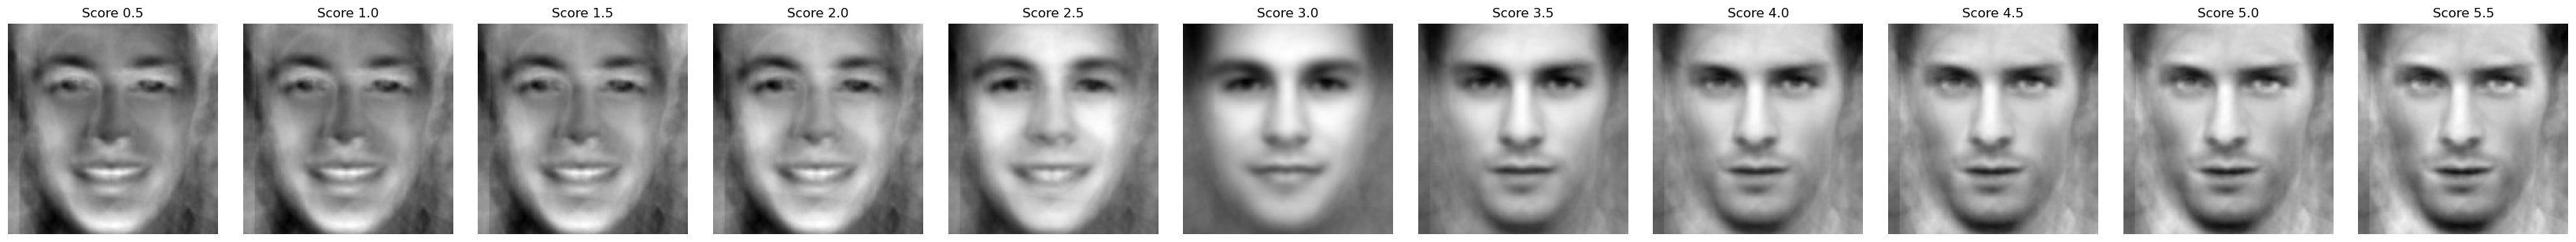

In [5]:
a = 5
delta = model_sel.intercept_  # intercept
weights = model_sel.coef_     # coefficients

scores = np.arange(0.5, 5.6, 0.5)
synth_images = []
for a in scores:
    # Compute the synthetic image in PC space
    j0 = (a - delta) / (np.dot(weights, weights)) * weights
    # Reconstruct the image in pixel space
    x0 = mean_image + j0 @ W[selected_idx]
    synth_images.append(x0.reshape((h, w)))

fig, axes = plt.subplots(1, len(scores), figsize=(3 * len(scores), 3))
for i, (img, a) in enumerate(zip(synth_images, scores)):
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Score {a}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()